# PathIntegrate Unsupervised Extension Guide

Package Documentation: https://cwieder.github.io/PathIntegrate/ 

Unsupservised Extension: https://github.com/judepops/MultiomicsML/PathIntegrate_JP

## Dependencies

In [1]:
# Classic Dependencies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sspa

# PathIntegrate Package
import pathintegrate_extension

## Loading the Multi-omics Datasets and Metadata

## Data Source

The dataset we will be working with is from Su et al. "Multi-Omics Resolves a Sharp Disease-State Shift between Mild and Moderate COVID-19".


* Plasma metabolomics (Metabolon UHPLC-MS/MS)
* Proteomics (Olink) datasets

with matched samples, of which 45 samples had ‘mild’ COVID (WHO status 1-2), and 82 had ‘moderate-severe’ COVID19 (WHO status 3-7), totalling 127 samples

Su Y, Chen D, Yuan D, Lausted C, Choi J, Dai CL, et al. Multi-Omics Resolves a Sharp Disease-State Shift between Mild and Moderate COVID-19. Cell. 2020;183: 1479-1495.e20. [DOI](doi:10.1016/j.cell.2020.10.037)



## Identifier harmonisation

*   Feature IDs have been converted to ChEBI for metabolites and UniProt for proteins
*   sspa package provides metabolite ID conversion utility
* IDs must match those of the pathway database
  * Reactome uses ChEBI, UniProt, and ENSEMBL
  * KEGG uses KEGG compound and KEGG gene

## Data pre-treatment

* Outlying samples should be removed
* Missing data should be imputed
* Features should be roughly normally distributed
* Features *do not need* to be scaled, this is applied internally in the model using StandardScaler (mean = 0, SD =1)

# Unsupervised Workflow: Preparing PathIntegrate Models

### Loading Example Data (within package)


In [ ]:
# This is available in the original pathintegrate package (with original data)

metab = pathintegrate.load_example_data('metabolomics')
prot = pathintegrate.load_example_data('proteomics')

### Loading your own data (optional)

The data is a matrix of sample ID rows by compound ID columns - this is molecular data (not sspa transformed)

In [2]:
# Using data from the files I have uploaded!

metab = pd.read_csv('Tutorial_Data/metabolomics_data.csv', index_col='sample_id')
prot = pd.read_csv('Tutorial_Data/proteomics_data.csv', index_col='sample_id')

In [4]:
# Visualising the data
## Both datasets have 4 columns of metadata at the end: Condition_Group, Age_Group, Race_Group and Who_Group

metab

,17388,16610,16797,27823,30915,18344,37373,16831,17050,16359,...,31885,30747,89188,89748,134398,195382,Condition_Group,Age_Group,Race_Group,Who_Group
sample_id,,,,,,,,,,,,,,,,,,,,,
INCOV001,-0.309795,-0.502641,-0.637667,-0.122857,0.474999,0.157153,-0.281768,-0.118232,-0.660474,-0.296199,...,1.019973,1.173283,-0.364810,1.081692,1.069490,-0.651579,Severe,70-79,White,3-4
INCOV002,-0.699692,-0.831709,1.111382,-0.334629,-1.105763,-0.174355,0.076942,-0.502073,-0.845703,-0.498400,...,-0.155821,0.718304,0.096048,-0.796873,-0.075605,0.577289,Severe,30-39,White,5-7
INCOV003,-0.887984,-0.397353,-0.438116,-0.232541,-0.993112,-0.020686,1.519644,-0.077480,-0.675463,-0.248810,...,0.106055,-1.991487,0.138473,-0.090819,0.338192,-1.023446,Severe,60-69,White,5-7
INCOV004,-0.326908,-1.032957,-0.108039,-0.458793,0.425355,0.004541,-0.008149,0.016055,-1.167311,-0.502574,...,-0.145739,-0.203595,-0.218725,0.039137,-0.173739,-0.371246,Severe,70-79,White,3-4
INCOV005,-0.771917,0.202121,-0.451401,-0.273589,0.485611,-0.122961,0.182271,-0.264262,-1.046298,-0.240914,...,-0.141714,-1.117976,-0.691423,1.447645,0.014378,-1.132785,Severe,70-79,White,3-4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
INCOV135,-1.729711,-0.542156,1.326848,-0.319301,-0.372402,0.011629,0.037108,-0.376014,-0.565223,-0.402929,...,-0.573600,0.135717,-0.786799,0.011331,-0.227069,0.068375,Mild,50-59,White,1-2
INCOV136,-0.584250,0.522303,-0.400936,-0.326393,-0.951822,-0.360384,0.388984,-0.266928,0.776850,0.316768,...,-0.539476,-0.317228,-0.617646,-0.681701,-0.272737,-0.818549,Severe,40-49,Other,3-4
INCOV137,0.165391,-0.046473,0.083743,0.023978,-1.357338,0.817028,0.198285,-0.128396,-0.204056,-0.557019,...,1.518151,0.440204,-0.755286,0.034898,0.932149,-0.572833,Severe,50-59,Black or African American,5-7


### Loading the Reactome multi-omics Pathways

In [5]:
# Download and save

mo_paths = sspa.process_reactome(
    organism='Homo sapiens',
    download_latest=True,
    omics_type='multiomics',
    filepath='.' # save to current directory
)

Beginning Reactome download...
Reactome DB file saved to ./Reactome_Homo_sapiens_pathways_multiomics_R89.gmt
Complete!


In [6]:
# Manually load in using sspa function (pre-downloaded)

mo_paths = sspa.process_gmt(infile='Tutorial_Data/Reactome_Homo_sapiens_pathways_multiomics_R85.gmt')
mo_paths = mo_paths.astype('object')

In [19]:
mo_paths

,Pathway_name,2,3,4,5,6,7,8,9,10,...,4095,4096,4097,4098,4099,4100,4101,4102,4103,4104
Pathway_ID,,,,,,,,,,,,,,,,,,,,,
R-HSA-1059683,Interleukin-6 signaling,P42224-1,O60674,P23458,P42224,P05231,O14543,P40189-1,P29597,P40189-2,...,,,,,,,,,,
R-HSA-109581,Apoptosis,Q01094,Q9UKG1,P28074,P31947,A5LHX3,P40763,P08571,P49354,Q13177,...,,,,,,,,,,
R-HSA-109582,Hemostasis,O14492,Q06033,Q6UXV4,P07359,P01591,Q9HAQ2,O94919,P01615,Q14624,...,,,,,,,,,,
R-HSA-109606,Intrinsic Pathway for Apoptosis,P30419,P42574,Q01094,Q14790,P28482,P55957,O60443,O14727,P31947,...,,,,,,,,,,
R-HSA-109703,PKB-mediated events,Q13370,P31751,,,,,,,,...,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R-HSA-983695,Antigen activates B Cell Receptor (BCR) leadin...,P01593,P01871,P06310,P01615,A0A075B6P5,P01619,P06315,P01624,P01705,...,,,,,,,,,,
R-HSA-983705,Signaling by the B Cell Receptor (BCR),P01593,P01871,P06310,Q8IV61,P28074,P01615,A5LHX3,A0A075B6P5,P01619,...,,,,,,,,,,
R-HSA-983712,Ion channel transport,Q9NTM9,Q9HBG4,P21283,Q8TEL6,Q9Y5S1,O76090,Q9NQ90,Q16515,Q4KMQ2,...,,,,,,,,,,


### Initiating a PathIntegrate Object (same protocol as supervised)

* pi_model is the pathintegrate model
* the metadata has to be removed from metabolomics and proteomics input into the model
* metadata to keep can be provided to the metadata columns

The samples match between proteomics and metabolomics data so only one dataframe needs to be used to provide the metadata (this will be apended by index)

Who_Group Metadata

In [8]:
pi_model_who = pathintegrate_extension.PathIntegrate(
    omics_data={'Metabolomics': metab.iloc[:, :-4], 'Proteomics':prot.iloc[:, :-4]}, # dictionary of multi-omics DataFrames and names for each omics
    metadata=prot['Who_Group'], # metadata column
    pathway_source=mo_paths, # pathways dataframe
    sspa_scoring=sspa.sspa_SVD, # ssPA method, see ssPA package for options
    min_coverage=2) # minimum number of molecules mapping per pathway to be included

Age_Group Metadata for Comparison

In [9]:
pi_model_age = pathintegrate_extension.PathIntegrate(
    omics_data={'Metabolomics': metab.iloc[:, :-4], 'Proteomics':prot.iloc[:, :-4]}, # dictionary of multi-omics DataFrames and names for each omics
    metadata=prot['Age_Group'], # metadata column
    pathway_source=mo_paths, # pathways dataframe
    sspa_scoring=sspa.sspa_SVD, # ssPA method, see ssPA package for options
    min_coverage=2) # minimum number of molecules mapping per pathway to be included

# Unsupervised Workflow: Performing Dimensionality Reduction

## A) Linear Model - PCA supported

In [7]:
# All models are available via sklearn 
import sklearn

PCA is offered for linear dimensionality Reduction
* model: sklearn.decomposition.PCA

Boolean variables:
* model_params: number of components: defaults to two as this is essential for a biplot
* return_pca_plot: this returns a PCA plot the the user
* metadata_continuous: this provides a gradient colour scheme for plotting continous variables (e.g increasing who status/ age). Numbers are ranked from high to low
* return_biplot: this provides a biplot to the user to visualise the pca loadings
* return_loadings_plot: this plots the loadings, converting pathway IDs to pathway names to understand the pathways that are driving PC1 and PC2

Generating pathway scores...
Fitting SingleView Dimensionality Reduction model


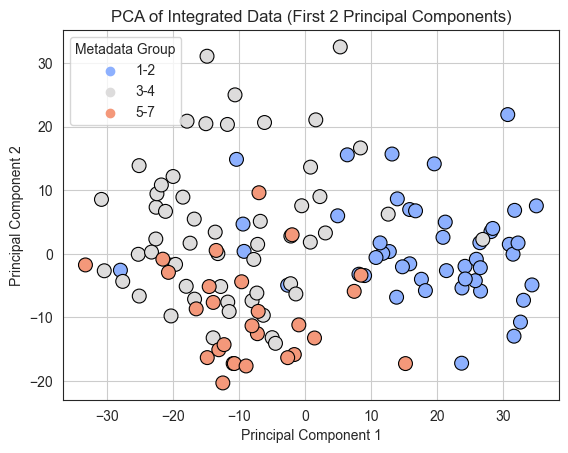

<Figure size 640x480 with 0 Axes>

In [19]:
covid_dimred = pi_model_who.SingleViewDimRed(model = sklearn.decomposition.PCA, return_pca_plot=True, metadata_continuous=True)

Generating pathway scores...
Fitting SingleView Dimensionality Reduction model


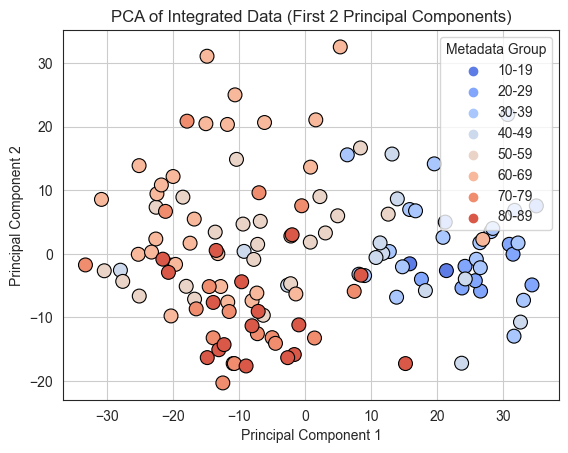

<Figure size 640x480 with 0 Axes>

In [10]:
# Doing the same wtih Ages, but with continuous scale based on age 

covid_dimred = pi_model_age.SingleViewDimRed(model = sklearn.decomposition.PCA, return_pca_plot=True, metadata_continuous=True)

Generating pathway scores...
Fitting SingleView Dimensionality Reduction model


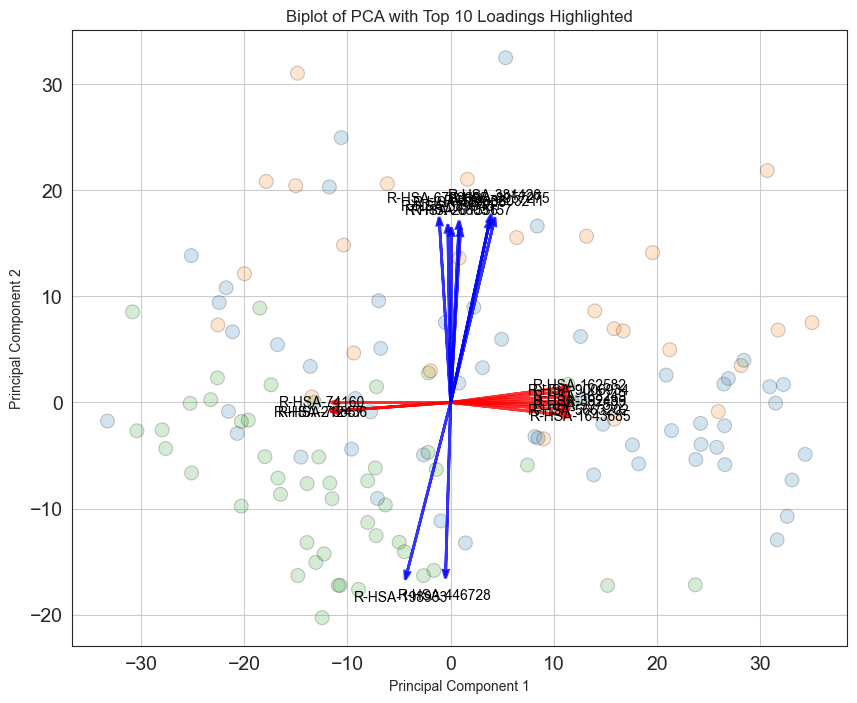

In [8]:
covid_dimred = pi_model_who.SingleViewDimRed(model = sklearn.decomposition.PCA, return_biplot=True)

Generating pathway scores...
Fitting SingleView Dimensionality Reduction model


<Figure size 1500x600 with 0 Axes>

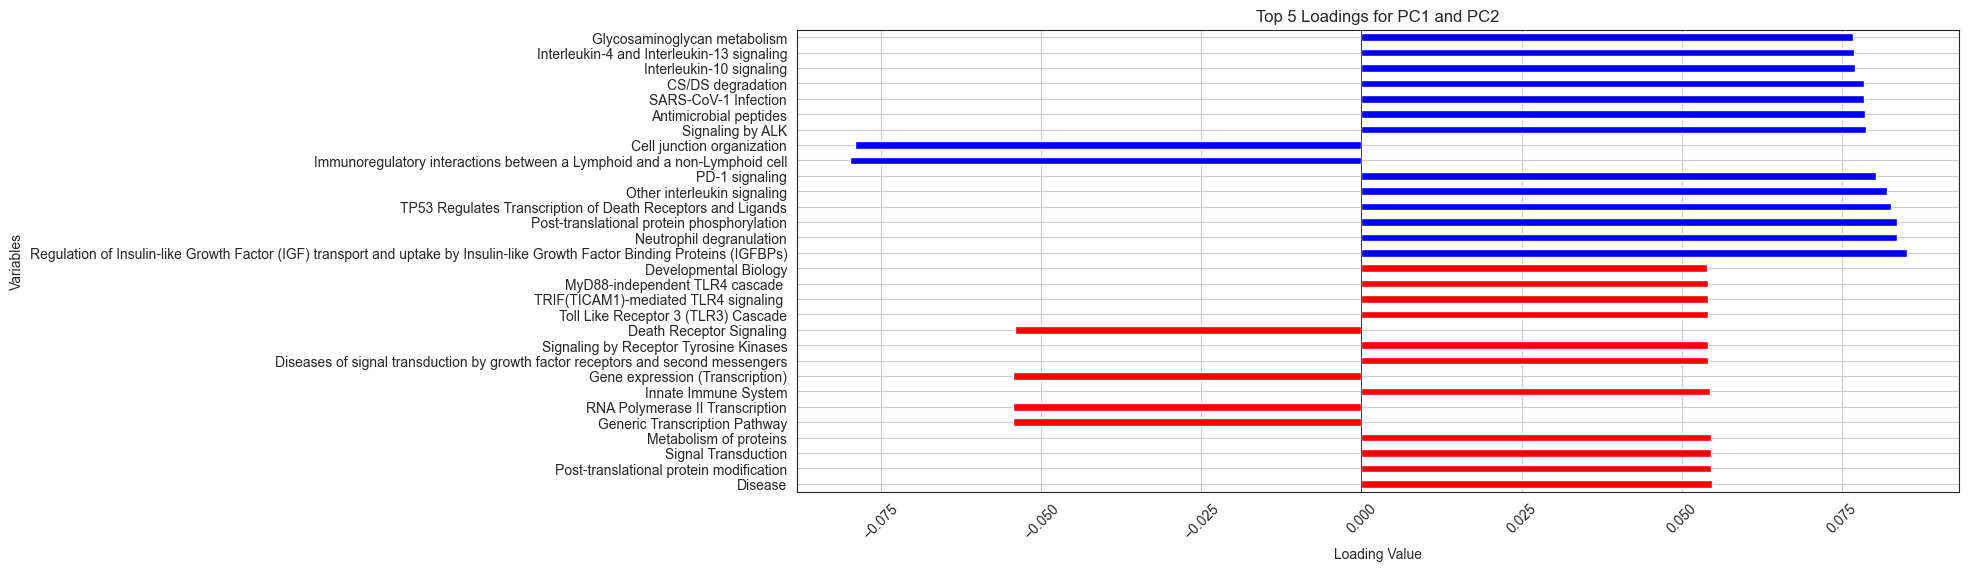

<Figure size 640x480 with 0 Axes>

In [9]:
covid_dimred = pi_model_who.SingleViewDimRed(model = sklearn.decomposition.PCA, return_loadings_plot=True)

## B) Non-Linear Model - t-SNE Supported

t-SNE is offered for non-linear dimensionality Reduction
* model: sklearn.manifold.TSNE

Boolean variables:
* model_params: defaults to two components as this is essential for t-SNE
* return_tsne_plot: this returns a t-SNE plot the the user
* metadata_continuous: this provides a gradient colour scheme for plotting continous variables (e.g increasing who status/ age). Numbers are ranked from high to low
* return_tsne_density_plot: this is the same t-SNE plot but with a density overlay, showing the concentration of points within each metadata group across the plot.

Generating pathway scores...
Fitting SingleView Dimensionality Reduction model


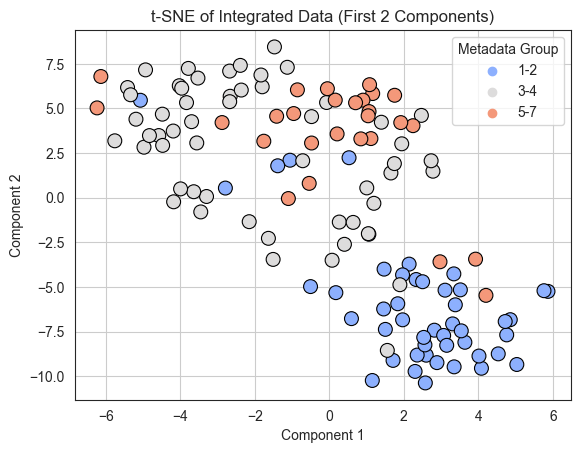

<Figure size 640x480 with 0 Axes>

In [18]:
covid_dimred = pi_model_who.SingleViewDimRed(model = sklearn.manifold.TSNE, return_tsne_plot=True, metadata_continuous=True)

Generating pathway scores...
Fitting SingleView Dimensionality Reduction model


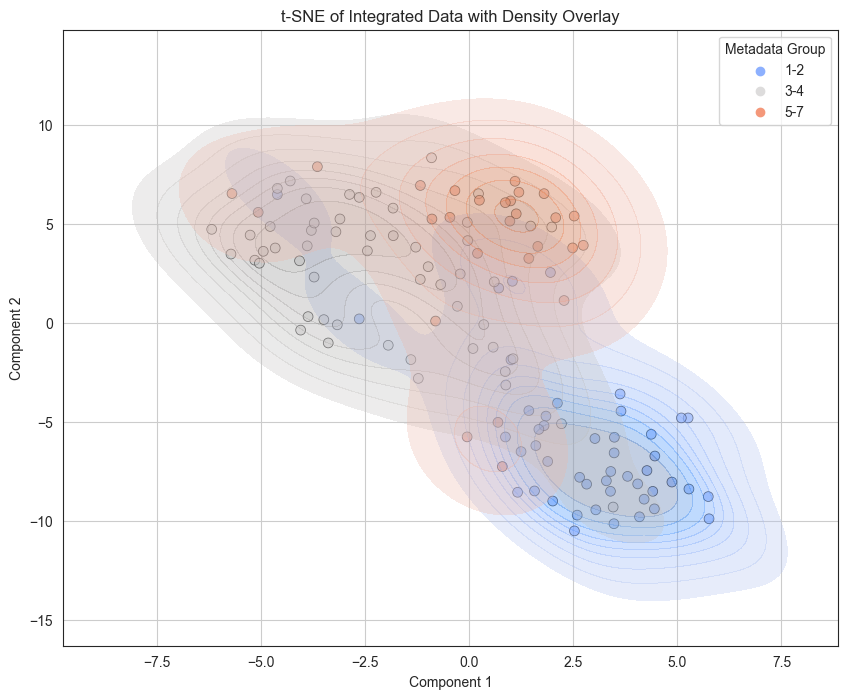

<Figure size 640x480 with 0 Axes>

In [31]:
covid_dimred = pi_model_who.SingleViewDimRed(model = sklearn.manifold.TSNE, return_tsne_density_plot=True, metadata_continuous=True)

Generating pathway scores...
Fitting SingleView Dimensionality Reduction model


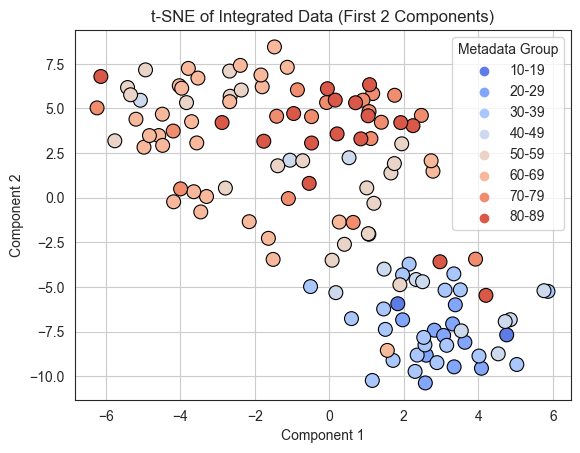

<Figure size 640x480 with 0 Axes>

In [17]:
# example for age
covid_dimred = pi_model_age.SingleViewDimRed(model = sklearn.manifold.TSNE, return_tsne_plot=True, metadata_continuous=True)

## Viewing Saved Data (plots are saved in object)

It is possible to create all the plots at once

Generating pathway scores...
Fitting SingleView Dimensionality Reduction model


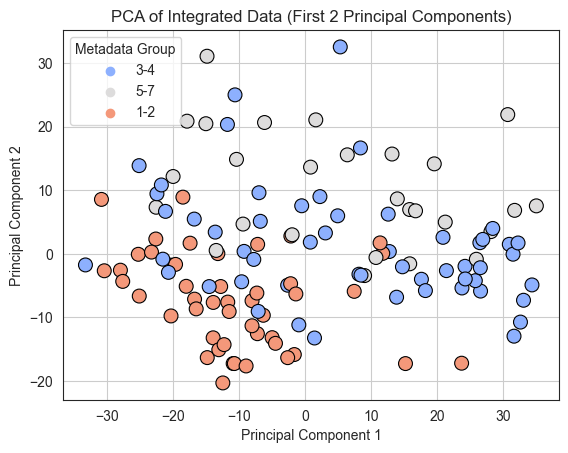

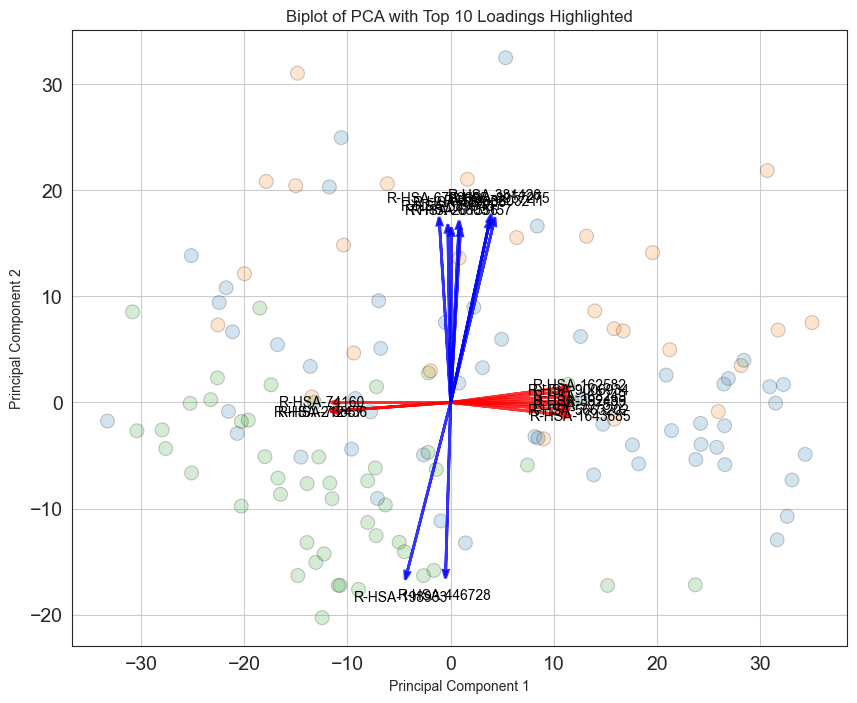

<Figure size 1500x600 with 0 Axes>

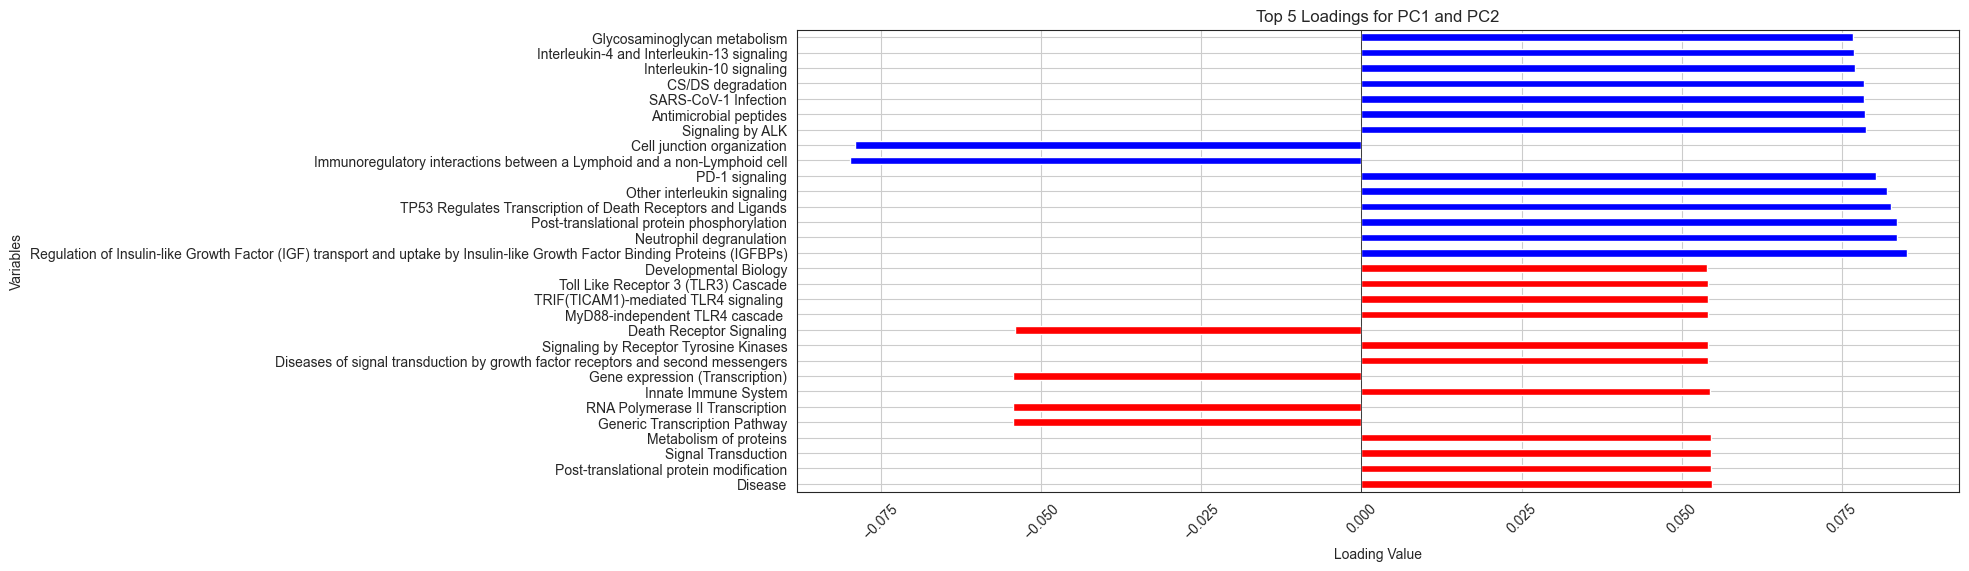

<Figure size 640x480 with 0 Axes>

In [20]:
covid_dimred_all = pi_model_who.SingleViewDimRed(model = sklearn.decomposition.PCA, metadata_continuous=False, return_pca_plot=True, return_biplot=True, return_loadings_plot=True)

Data:

In [ ]:
#covid_dimred_all.biplot
#covid_dimred_all.loadings_plot
#covid_dimred_all.pca_plot

In [28]:
# Integrated Matrix (proteomics and metabolomics)

covid_dimred_all.sspa_scores_pca

,R-HSA-109581,R-HSA-109582,R-HSA-109606,R-HSA-109704,R-HSA-110331,R-HSA-110362,R-HSA-110373,R-HSA-111465,R-HSA-112310,R-HSA-112311,...,R-HSA-9818027,R-HSA-9824439,R-HSA-9824443,R-HSA-9824446,R-HSA-983168,R-HSA-983169,R-HSA-983231,R-HSA-983695,R-HSA-983705,R-HSA-983712
sample_id,,,,,,,,,,,,,,,,,,,,,
INCOV001,3.322375,4.140705,-2.603474,0.212413,0.660943,-1.022096,-1.022096,1.776142,-0.225829,-0.479240,...,1.787114,-1.171277,0.649333,4.698076,-1.904744,3.247835,2.373124,1.616120,2.011338,0.026124
INCOV002,1.716907,3.028423,-0.195328,2.061935,-0.072868,0.951863,0.951863,0.937931,0.573098,-1.068177,...,0.668390,-0.191179,3.576688,1.493449,-0.506822,1.474905,0.855766,0.792209,1.450128,-0.707189
INCOV003,3.205253,3.247036,-1.222398,1.519523,1.226663,-0.954084,-0.954084,2.011921,0.406322,0.339261,...,1.673103,-1.245140,2.663711,2.101843,-1.548265,1.592421,1.280815,0.768717,1.239043,-1.439872
INCOV004,5.217176,6.949524,-3.478906,2.890549,-0.479690,-2.531685,-2.531685,3.296429,-0.384492,-1.812504,...,2.850724,-1.639426,2.914821,6.188444,-3.415879,4.696012,2.589770,2.758843,3.395721,1.385751
INCOV005,3.941574,5.923233,-2.425999,0.781600,-0.389761,-1.330461,-1.330461,1.933067,-0.530185,-1.479107,...,1.284374,-2.046109,3.142288,4.031748,-1.194195,2.903968,1.309147,1.730673,2.419191,-1.061310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
INCOV135,2.204968,4.397612,-1.658258,0.593418,-0.366401,-1.553488,-1.553488,1.897204,-0.847269,-1.353430,...,1.026030,-1.133267,-0.614668,4.229433,-1.534312,2.980587,1.723357,1.012350,1.597349,-0.747592
INCOV136,-2.498859,-3.475529,1.354611,-0.272846,0.357881,1.317970,1.317970,-1.972106,-1.963316,-0.103883,...,-1.592074,3.087492,-1.666615,-3.465738,0.569077,-0.649875,-1.597189,-1.329584,-1.393713,0.467576
INCOV137,-2.164974,-2.695749,1.354870,1.047841,0.327905,0.271528,0.271528,-0.987798,-0.129776,0.903427,...,-1.205370,1.763120,-0.901692,-2.367886,1.490835,-1.137790,-1.331120,-0.747404,-0.727417,2.735410


In [23]:
# PC1 and PC2 explaiend variance

covid_dimred_all.explained_variance

array([0.43535564, 0.14528455])

In [25]:
# PCA Loadings

covid_dimred_all.loadings_df

,Component 1,Component 2
Apoptosis,0.053589,-0.009901
Hemostasis,0.053341,-0.015723
Intrinsic Pathway for Apoptosis,-0.049337,0.015913
PI3K Cascade,0.016267,-0.034302
Cleavage of the damaged purine,-0.021507,0.002250
...,...,...
Class I MHC mediated antigen processing & presentation,0.049944,-0.031289
Factors involved in megakaryocyte development and platelet production,0.048423,-0.030047
Antigen activates B Cell Receptor (BCR) leading to generation of second messengers,0.049028,0.014498
Signaling by the B Cell Receptor (BCR),0.051392,-0.004987


# Unsupervised Workflow: Performing Clustering

All models are also available via scikit learn

KMeans (Partitioning Method), AgglomerateClustering (Hierarchical Method) and Birch (Balanced Iterative Reducing and Clustering using Hierarchies) are offered for clustering
* from sklearn.cluster import KMeans, AgglomerativeClustering, Birch

Boolean variables:
* model: model can be one of the models above: simply load in the model using sklearn and set it as the model
* model_params: this is the number of clusters to find: if no number is provided, the model will automatically provide the best number using average sillhouette score
* consensus_clustering: this is a custom, bootstrap resampling algorithm that identifies the best clustering profile by comparing which samples are clustered together over multiple runs
** n_runs provides a number of how many runs to run within each consensus cluster e.g 10 runs would be a consensus that averages 10 runs
* use_pca: this is reccomended and runs PCA before clustering to achieve better seperation of samples and better clsutering results
* return_plot: this returns the clsutering profile to the user to visualise the clusters
* return_metrics_table: this provides a table of the metrics 

If there is ground truth: 
* return_ground_truth: this returns a ground truth plot to compare the clustering profile to the true answer
* return_comparison_plot: this provides a confusion matrix to compare how sample groups compare to clusters

### Clustering with and without PCA

### Different clustering numbers with consensus clustering:

Generating pathway scores...
Performing PCA...
Run 1/20
Run 2/20
Run 3/20
Run 4/20
Run 5/20
Run 6/20
Run 7/20
Run 8/20
Run 9/20
Run 10/20
Run 11/20
Run 12/20
Run 13/20
Run 14/20
Run 15/20
Run 16/20
Run 17/20
Run 18/20
Run 19/20
Run 20/20
Calculating clustering metrics...


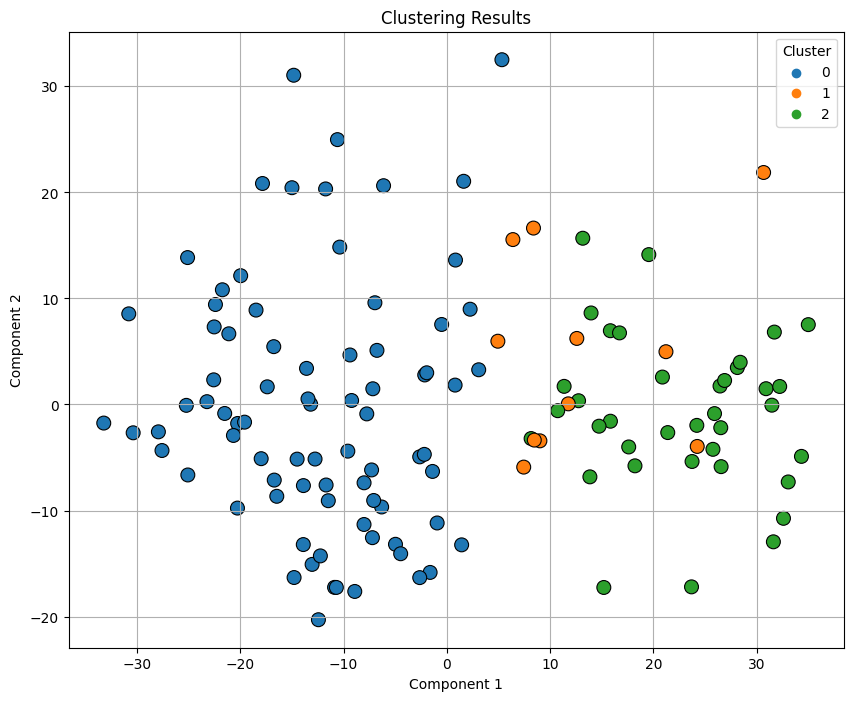

Finished


In [8]:
covid_kmeans = pi_model_who.SingleViewClust(model_params={'n_clusters' : 3},consensus_clustering=True, n_runs=20, return_plot=True)

Generating pathway scores...
Performing PCA...
Run 1/20
Run 2/20
Run 3/20
Run 4/20
Run 5/20
Run 6/20
Run 7/20
Run 8/20
Run 9/20
Run 10/20
Run 11/20
Run 12/20
Run 13/20
Run 14/20
Run 15/20
Run 16/20
Run 17/20
Run 18/20
Run 19/20
Run 20/20
Calculating clustering metrics...


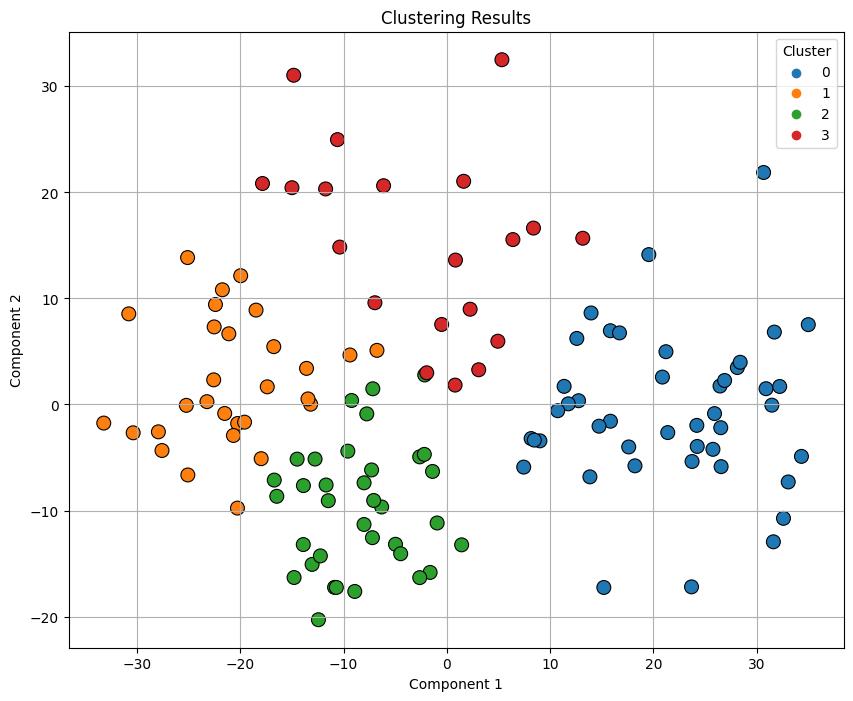

Finished


In [9]:
covid_kmeans = pi_model_who.SingleViewClust(model_params={'n_clusters' : 4},consensus_clustering=True, n_runs=20, return_plot=True)

## Automatically determining the number of clusters

Need to chose at least 2 clustres as minimim for average silhouette score and then any max

Generating pathway scores...
Performing PCA...
Determining optimal number of clusters...
Optimal number of clusters determined: 2
Calculating clustering metrics...


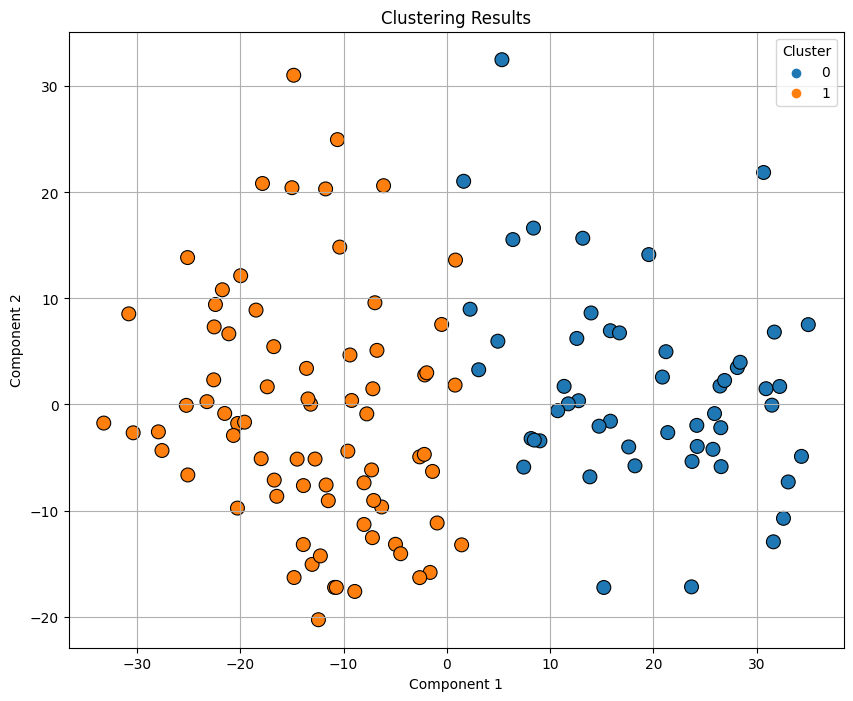

Finished


In [14]:
# without model params, the ASW is used to identify an automatic amount of clusters 
# 7 clusters are chosen as teh most suitable by ASW
covid_kmeans = pi_model_who.SingleViewClust(model=sklearn.cluster.KMeans, use_pca=True, auto_n_clusters=True, n_clusters_range=(2, 20), return_plot=True)

### Clustering and comparing to ground truth Who Groups - showing ground truth plot, confusion matrix and metrics (ARI is most important)

Generating pathway scores...
Performing PCA...
Calculating clustering metrics...


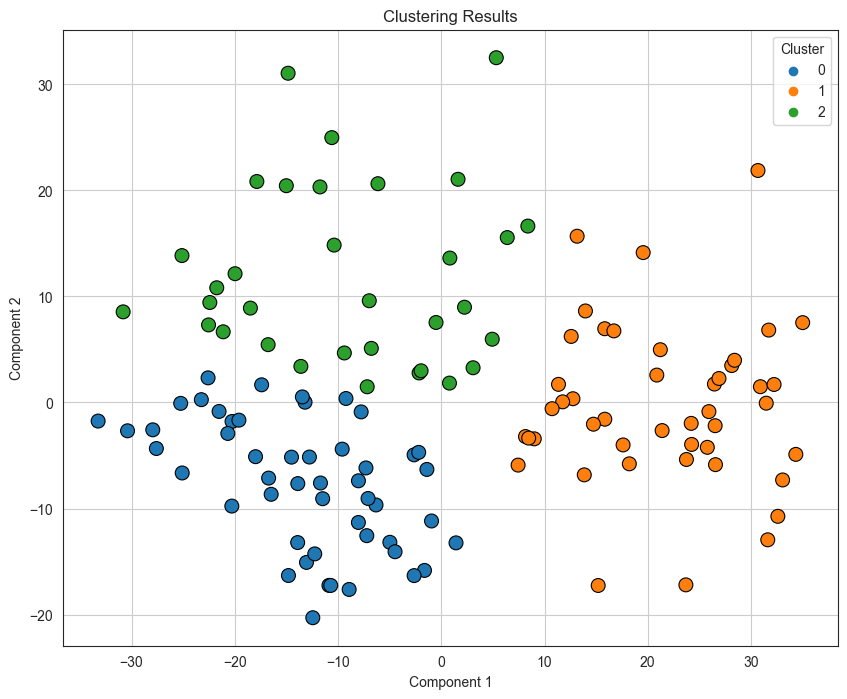

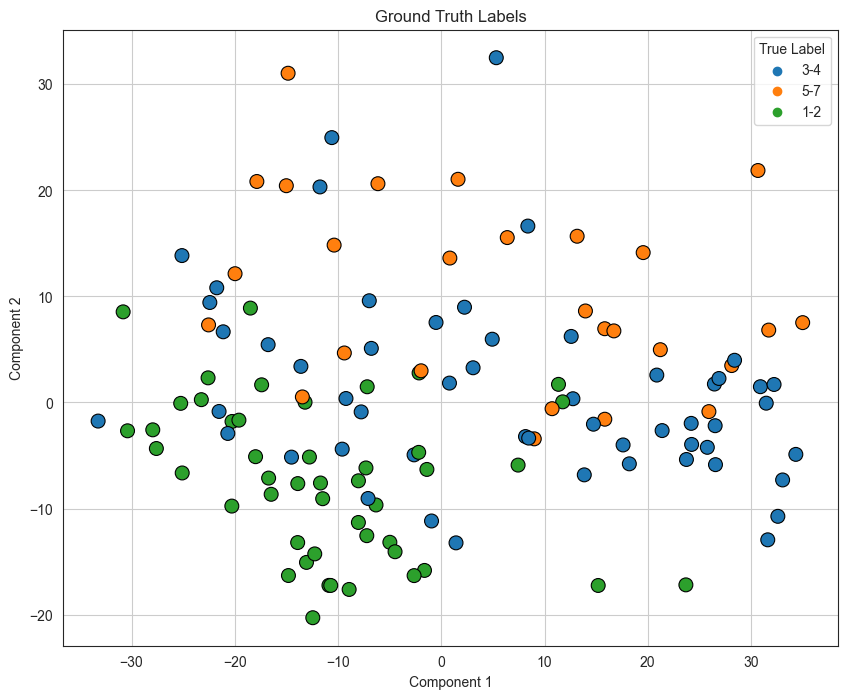

Adjusted Rand Index (ARI) Score: 0.2318


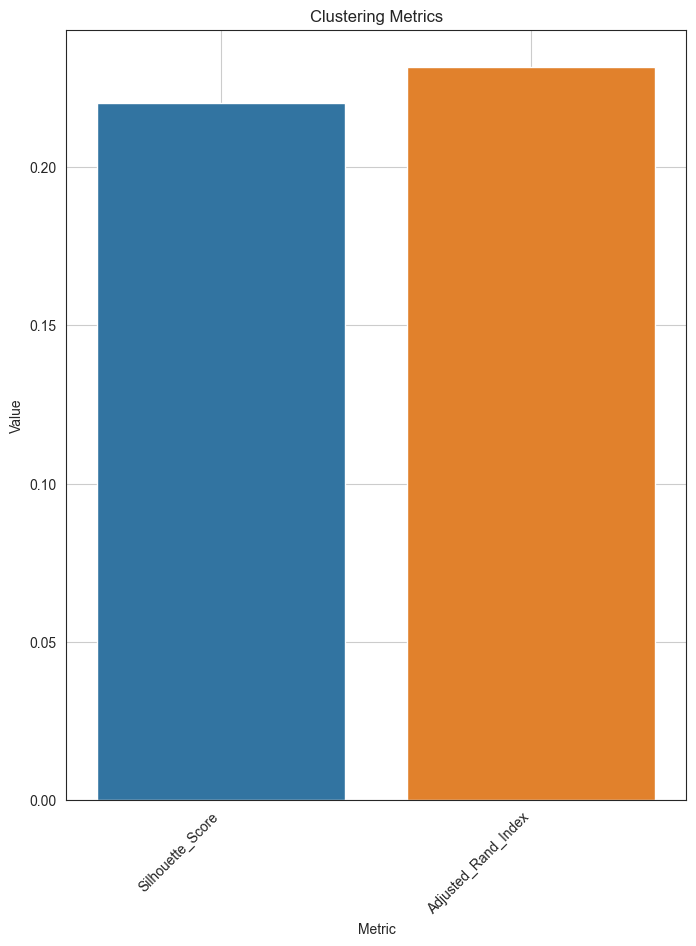

Finished


In [43]:
covid_kmeans = pi_model_who.SingleViewClust(model_params={'n_clusters' : 3}, use_pca=True, return_plot=True, return_comparison_plot=True, return_metrics_table=True, return_ground_truth_plot=True)

## Using and comparing different clustering algorithms

In [15]:
# Loading different algorithms
from sklearn.cluster import KMeans, AgglomerativeClustering, Birch

Generating pathway scores...
Performing PCA...
Calculating clustering metrics...


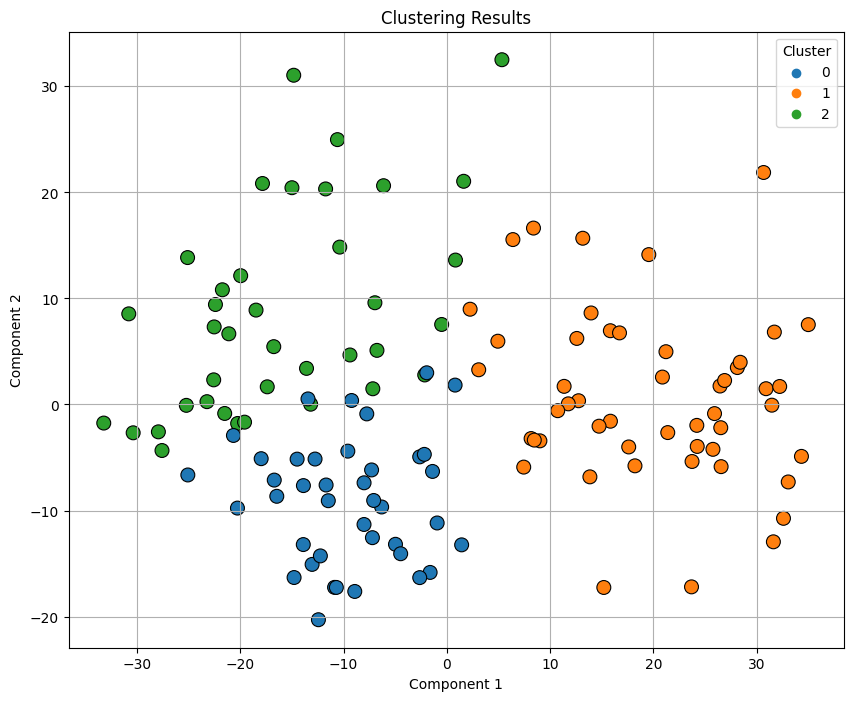

Finished


In [17]:
covid_kmeans = pi_model_who.SingleViewClust(model=KMeans, use_pca=True, model_params={ 'n_clusters':3}, return_plot=True)

Generating pathway scores...
Performing PCA...
Calculating clustering metrics...


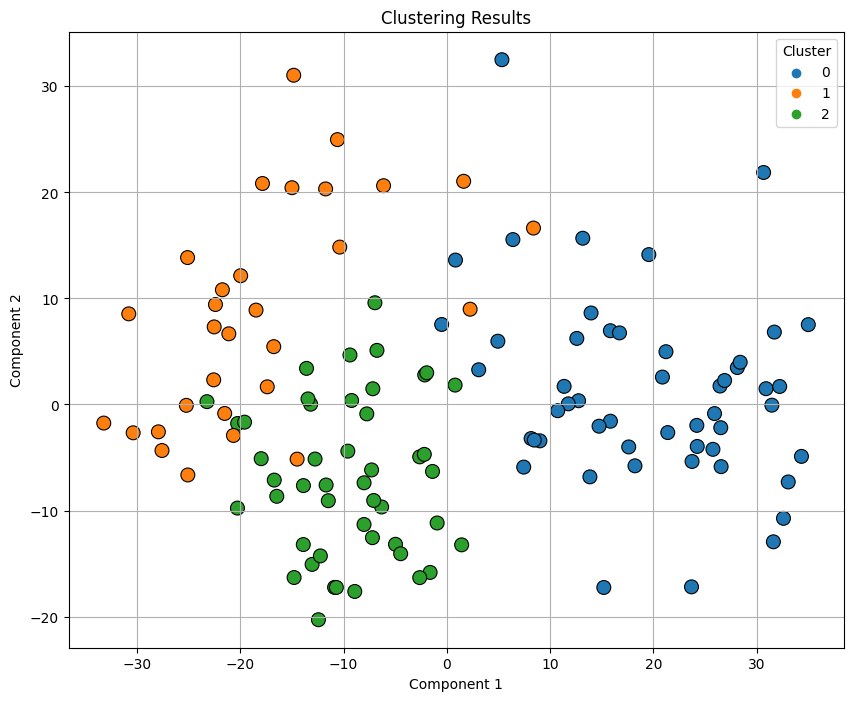

Finished


In [18]:
covid_kmeans = pi_model_who.SingleViewClust(model=AgglomerativeClustering, use_pca=True, model_params={'n_clusters':3}, return_plot=True)

Generating pathway scores...
Performing PCA...
Calculating clustering metrics...


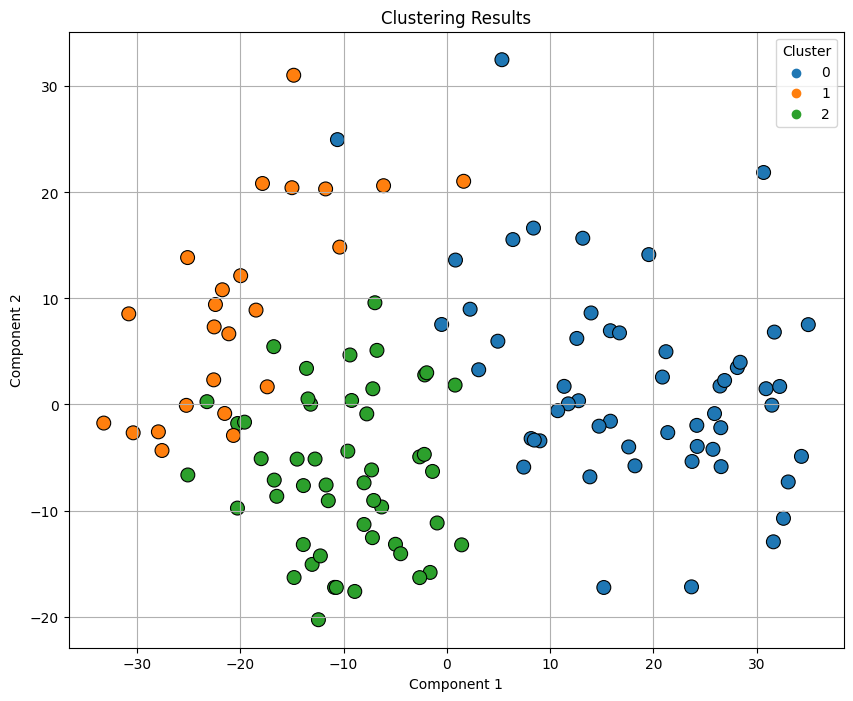

Finished


In [19]:
covid_kmeans = pi_model_who.SingleViewClust(model=Birch, use_pca=True, model_params={'n_clusters':3}, return_plot=True)